<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Entities" data-toc-modified-id="Entities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Entities</a></span></li><li><span><a href="#Lanes" data-toc-modified-id="Lanes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Lanes</a></span></li><li><span><a href="#Vehicles" data-toc-modified-id="Vehicles-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Vehicles</a></span><ul class="toc-item"><li><span><a href="#Surroundings-of-car" data-toc-modified-id="Surroundings-of-car-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Surroundings of car</a></span></li></ul></li><li><span><a href="#Recorder" data-toc-modified-id="Recorder-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Recorder</a></span></li><li><span><a href="#Multiple-Vehicles-with-Fixed-Speed" data-toc-modified-id="Multiple-Vehicles-with-Fixed-Speed-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Multiple Vehicles with Fixed Speed</a></span></li><li><span><a href="#Generating-Random-Speeds" data-toc-modified-id="Generating-Random-Speeds-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Generating Random Speeds</a></span></li><li><span><a href="#Simulating-Cars-on-Lanes" data-toc-modified-id="Simulating-Cars-on-Lanes-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Simulating Cars on Lanes</a></span><ul class="toc-item"><li><span><a href="#Average-Time" data-toc-modified-id="Average-Time-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Average Time</a></span></li><li><span><a href="#Throughput" data-toc-modified-id="Throughput-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Throughput</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Plots</a></span></li></ul></li></ul></div>

# Libraries

In [1]:
#Importing all the libraries required for the project.
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random

import simpy

In [2]:
ε = 0.00001

def isZero(x):
    return abs(x)<ε

# Entities

In [3]:
# Time tolerance: when at current speed difference a crash might occur within that number of seconds
CRITICAL_TIME_TOLERANCE = 4  # [s] 
LANE_CHANGE_TIME = 2 # [s]
MIN_TIME_DIFF = 0.5

MIN_SPEED_DIFF = 3 # [m/s] min speed diff to trigger overtaking

CAR_LENGTH = 4 # [m]

FAR_AWAY_IN_FRONT = 200 # [m]  distance at which a car in front can be ignored
FAR_AWAY_IN_BACK = 80   # [m]  distance at which a car behind can be ignored

# Lanes

In [4]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

In [5]:
LANE_ID = 0

class Lane:
    
    ## some additional code
    def __init__(self, length, speedLimit):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
        
        self.length = length
        self.speedLimit = speedLimit
        self.vehicles = []
        
        self.next = None
        self.prev = None
        
        # lane attached to the left/right
        self.left = None
        self.right = None
      
    # defines generic str() method for Lanes
    # extends the method with list of vehicles on the lane
    def __str__(self):
        l = "" if self.left is None else f" L:{self.left.id:d}"
        r = "" if self.right is None else f" R:{self.right.id:d}"
        vs = "" if len(self.vehicles)==0 else " "
        for v in self.vehicles:
            vs += str(v)
        return f"[{self.id:d} {int(self.length):d}m"+l+r+vs+"]" + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
     
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenLeft(self):
        lane = self
        newLane = Lane(lane.length, lane.speedLimit)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(lane.length, lane.speedLimit)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
        
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.prev = l
        return self
    
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    ## additional code
    ## new generalised access method needed to calculate sideway view
    ## returns all vehicles between pos+distFrom and pos+distTo
    def at(self, pos, distFrom=-CAR_LENGTH/2, distTo=CAR_LENGTH/2):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if pos+distFrom < v.pos and v.pos < pos+distTo:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if pos+distTo > self.length and self.next is not None:
            res = res + self.next.at(0, distFrom=0, distTo=distTo-(self.length-pos))
        if pos+distFrom < 0 and self.prev is not None:
            res = self.prev.at(self.prev.length, distFrom=pos+distFrom, distTo=0) + res
        return res
        
    def inFront(self, pos, far=FAR_AWAY_IN_FRONT):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far=far-(self.length-pos))
        
    def behind(self, pos, far=FAR_AWAY_IN_BACK):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far=far-pos)
        
    def enter(self, vehicle, pos=0):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane")

    def leave(self, vehicle):
        vehicle.rec.record(vehicle, event="leave lane")
        vehicle.lane = None
        # in the meantime the vehicle may have have moved
        # to one of the next lane segments...
        lane = self
        while lane is not None:
            if vehicle in lane.vehicles:
                lane.vehicles.remove(vehicle)
                break
            else:
                lane = lane.next

# Vehicles

In [6]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [249]:
VEHICLE_ID = 0

class Vehicle:
    def __init__(self, env, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 t=[], v=[]):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        
        self.a_min = -3 # [m/s²]
        self.a_max = 2.5 # [m/s²] corresponds to 0-100km/h om 12s
        
        self.env = env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        ## second lane reference during changing of lanes
        self.oldLane = None
            
        self.t0 = t0
        self.x0 = x0
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0
        
        self.t = t
        self.v = v
        self.t_target = []
        self.v_target = []
        
        self.running = False
        self.crashed = False
        self.braking = False
        self.changingLane = False
        
        self.processRef = None
        self.env.process(self.process())
        
        ## this allows to trigger trace messages for
        ## the new feature Surround
        self.traceSurround = False
        self.traceOvertake = False
        self.traceBrake = False
    
    def __str__(self):
        return f"({self.id:d})"         
    
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    def updateOnly(self):
        if self.crashed:
            return False
        t = self.env.now
        if t < self.t0:
            return False
        if self.running and t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = round(self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2,4)
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
        return True
        
    def update(self):
        active = self.updateOnly()
        if not active:
            return False
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        if (isRunning(inFront) or isCrashed(inFront)) \
               and inFront.x0 < self.x0 + CAR_LENGTH:
            self.crash(inFront)
            return True

        if inFront is not None and not self.braking and \
                self.dx0 > inFront.dx0 and \
                self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0 > inFront.x0:
            Δt = max(MIN_TIME_DIFF, (inFront.x0-self.x0)/self.dx0)
            self.setTarget(Δt, inFront.dx0)
            self.interruptProcess()
            return True
        
        ## new code: start overtaking maneuver by changing into fast lane
        if inFront is not None and \
                not self.braking and not self.changingLane and \
                self.dx0 > inFront.dx0 + MIN_SPEED_DIFF and \
                self.x0 + (LANE_CHANGE_TIME+CRITICAL_TIME_TOLERANCE)*self.dx0 > inFront.x0 and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} overtakes v{inFront.id:d} at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'fast')
            self.interruptProcess()
            return True
            
        ## new code: end overtaking by returning to slow lane
        if self.surround.leftLane is not None and \
                not self.braking and not self.changingLane and \
                self.surround.left is None and \
                self.isNotFasterThan(self.surround.leftFront) and \
                self.surround.leftBack is None:
            if self.traceOvertake:
                print(f"t={self.t0:7,.1f}s Overtaking v{self.id:d} returns to slow lane at x={self.x0:7,.1f}m")
            self.setTarget(LANE_CHANGE_TIME, 'slow')
            self.interruptProcess()
            return True
     
    def setTarget(self, Δt, v):
        self.t_target = [ Δt ] + self.t_target
        self.v_target = [ v ] + self.v_target
      
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = self.env.now
        self.running = True
        self.rec.startRecording(self)
        self.startingLane.enter(self, pos=self.startingPos)
        
        while self.running:
            self.updateOnly()
            
            self.surround = Surround(self)

            inFront = self.surround.front
            if inFront is not None:
                
                # if the car in front is slower and we are a bit too near on its heals...
                if inFront.dx0 < self.dx0 and \
                        inFront.x0 < self.x0 + CRITICAL_TIME_TOLERANCE*self.dx0:
                    if self.traceBrake:
                        print(f"t={self.t0:7,.1f}s Braking v{self.id:d} v={self.dx0:4.4f}m/s to {inFront.dx0:4.4f}")


                    yield from self.emergencyBraking(inFront.dx0)
                    if not isZero(self.dx0-inFront.dx0):
                        # after emergency breaking adjust to the speed of the car in front...
                        Δt = 2
                        self.setTarget(Δt, inFront.dx0)
                    continue 
        
            if len(self.t_target)==0:
                self.t_target = self.t.copy()
                self.v_target = self.v.copy()
                
            if len(self.t_target)>0:
                
                ## add code for explicit change of lane
                if type(self.v_target[0]) is str:
                    direction = normaliseDirection(self.v_target[0])
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(direction, t)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = self.v_target[0]
                    t = self.t_target[0]
                    self.t_target = self.t_target[1:]
                    self.v_target = self.v_target[1:]  
                    if isZero(v1-v0):
                        yield from self.wait(t)
                    else:
                        yield from self.adjustVelocity(v1-v0, t)
            else:
                yield from self.wait(10)
        
        self.rec.stopRecording(self)
  
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_min-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_min
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0

        
        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None
        self.braking = False
 
    ## make changeLane robust against interrupt:
    def changeLane(self, direction, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def changeLaneProcess(oldLane, newlane, Δt):
            self.updateOnly()
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            self.updateOnly()
            self.oldLane.leave(self)
            self.lane = newLane
            self.oldLane = None
            self.rec.record(self, 'done change '+direction)
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        self.changingLane = True
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4))
        self.changingLane = False

    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            self.updateOnly()
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt     
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
            
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
        
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            self.dddx0 = 0
            pass
        self.processRef = None

    def wait(self, Δt):
         
        def waitProcess():
            yield self.env.timeout(Δt) 
        
        self.processRef = self.env.process(waitProcess())
        try:
            yield self.processRef
        except simpy.Interrupt:
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('change')
            
    def crash(self, other):
        
        def recordCrash(self):
            self.rec.record(self, 'crash')
            self.running = False
            self.crashed = True
            self.dx0 = 0
            self.ddx0 = 0
            self.dddx0 = 0
            
        if self.running:
            print(f"Crash p{self.id:d} into p{other.id:d} at t={self.t0:7.3f} x={self.x0:7.1f}")
            recordCrash(self)
            if other.running:
                recordCrash(other)       

## Surroundings of car

In [8]:
class Surround:
    
    def __init__(self, vehicle):
        
        def s(vehicle):
            if vehicle is None:
                return " "
            elif type(vehicle) is list:
                if len(vehicle)==1:
                    return s(vehicle[0])
                else:
                    res = "["
                    for v in vehicle:
                        if len(res)>1:
                            res += ','
                        res+=s(v)
                    res += "]"
                    return res
            else:
                return f"{vehicle.id:d}"
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.leftBack = vehicle
        self.left = vehicle
        self.leftFront = vehicle
        self.back = vehicle
        self.vehicle = vehicle
        self.front = vehicle
        self.rightBack = vehicle
        self.right = vehicle
        self.rightFront = vehicle
        
        lane = vehicle.lane
        pos = vehicle.pos
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(pos)
            self.back = lane.behind(pos)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(pos)
                    self.rightBack = self.rightLane.behind(pos)
                else:
                    right = self.rightLane.at(pos)
                    if len(right)==0:
                        self.right = None
                    elif len(right)==1:
                        self.right = right[0]
                    else:
                        self.right = right

                    if self.right is None:
                        self.rightFront = self.rightLane.inFront(pos)
                        self.rightBack = self.rightLane.behind(pos)
                    else:
                        self.rightFront = None
                        self.rightBack = None
                
            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(pos)
                    self.leftBack = self.leftLane.behind(pos)
                else:
                    left = self.leftLane.at(pos)
                    if len(left)==0:
                        self.left = None
                    elif len(left)==1:
                        self.left = left[0]
                    else:
                        self.left = left
                        
                    if self.left is None:
                        self.leftFront = self.leftLane.inFront(pos)
                        self.leftBack = self.leftLane.behind(pos)
                    else:
                        self.leftFront = None
                        self.lefttBack = None
                    
        if vehicle.traceSurround:
            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# Recorder

In [9]:
class SimpleRecorder:
    
    def __init__(self, env, startTime, stopTime, timeStep):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = env
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.vehiclesToTrace = []
        self.vehicles = []
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event'])

    # runs the simulation
    def run(self):       
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
        
    def startRecording(self, p):
        self.vehicles.append(p)
        
    def stopRecording(self, p):
        self.vehicles.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly():
                laneId = None if p.lane is None else p.lane.id
                oldLaneId = None if p.oldLane is None else p.oldLane.id
                if p.running or event!='timer':
                    ix = len(self.data)
                    self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, laneId, oldLaneId, p.pos, event] 
                    if event=='timer':
                        p.update()            
        else:
            for p in self.vehicles:
                self.record(p)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)

    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()
            yield self.env.timeout(self.timeStep)
            
    def plot(self, x, y, 
             vehicles=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(6, 4), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, '', data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            # use small circle to indicate emergency braking
            db = df[df.event=='brake']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
            
            # use black right pointing triangle
            # to indicate that a vehicle 
            # was changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black left pointing triangle
            # to indicate that a vehicle 
            # was changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
        plt.grid(True)

 # Multiple Vehicles with Fixed Speed
 

In [142]:
VMAX = 120/3
N = 100
DT = 1 # time difference between start
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 200, 1)

l = Lane(500, VMAX)
r = l.widenRight()
for i in range(N):
    v = Vehicle(env, rec, startingLane=l, t0=i*DT,dx0=10, t=[10], v=[50])
    v.traceOvertake = True
rec.run()

In [143]:
df = rec.getData()

In [144]:
df

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,10,0,0,0,None,0,enter lane
1,0,0,10,0,0,0,None,0,timer
2,1,0,10,0,1,0,None,0,enter lane
3,1,10.74,12.2222,4.44444,0,0,None,10.74,timer
4,1,0,10,0,1,0,None,0,timer
...,...,...,...,...,...,...,...,...,...
1695,112,500,49.9996,4.44444e-05,98,0,None,500,leave lane
1696,112,500,49.9996,4.44444e-05,98,None,None,500,end
1697,112,450,49.9996,4.44444e-05,99,0,None,450,timer
1698,113,500,49.9996,4.44444e-05,99,0,None,500,leave lane


In [145]:
df[df["id"]==0].head(30)

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,10,0,0,0,None,0,enter lane
1,0,0,10,0,0,0,None,0,timer
3,1,10.74,12.2222,4.44444,0,0,None,10.74,timer
6,2,25.18,16.6666,4.44444,0,0,None,25.18,timer
10,3,44.07,21.111,4.44444,0,0,None,44.07,timer
15,4,67.4,25.5554,4.44444,0,0,None,67.4,timer
21,5,95.18,29.9998,4.44444,0,0,None,95.18,timer
28,6,127.4,34.4442,4.44444,0,0,None,127.4,timer
36,7,164.07,38.8886,4.44444,0,0,None,164.07,timer
45,8,205.18,43.333,4.44444,0,0,None,205.18,timer


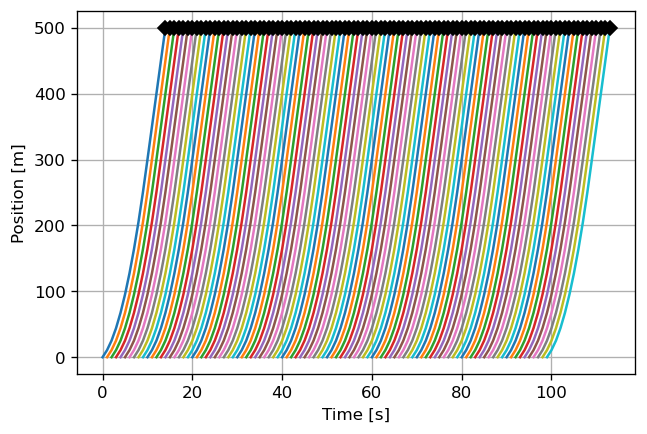

In [146]:
rec.plot('t', 'x')

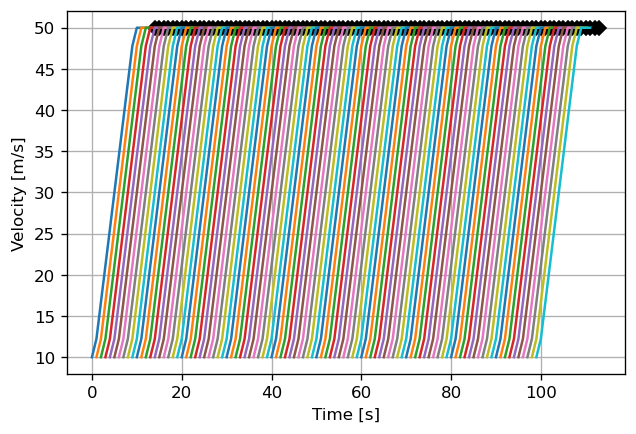

In [147]:
rec.plot('t', 'v')

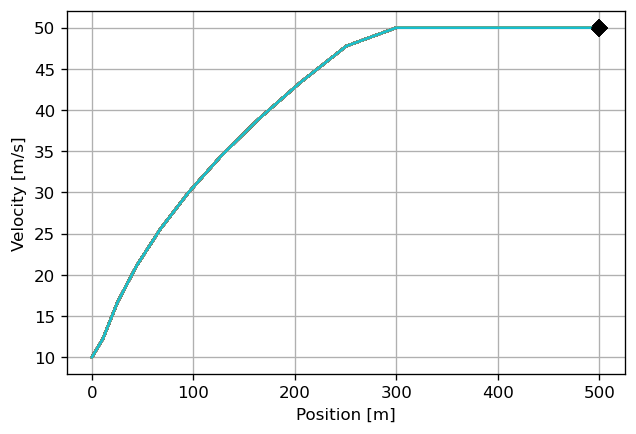

In [150]:
rec.plot('x', 'v')

# Generating Random Speeds

In [160]:
SLOW_CYCLE = 50

In [161]:
def randomIntervals(cycles):
    return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ]

In [162]:
randomIntervals(4)

[61.71565820389705, 54.492366626790606, 44.86981632217073, 54.255302046824156]

In [163]:
SPEED_VARIATION = 0.02
def randomSpeedVariation(vmax, cycles, cv=SPEED_VARIATION):
    return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*cv)) for i in range(cycles) ] 

In [164]:
randomSpeedVariation(40,4)

[40.27880258673209, 39.97258813413857, 40.955615346882766, 39.32531283897454]

# Simulating Cars on Lanes

In [444]:
VMAX = 130/3.6 #maximum speed of a car
N = 100 # number of cars
DT = 4 # time difference between start for each car
random.seed(13)
env = simpy.Environment()
rec = SimpleRecorder(env, 0, 1000, 1)

#Creating Lanes for simulation
l = Lane(1000, VMAX)
while l.totalLength()<3000:
    l.extend(Lane(1000, VMAX))
r = l.widenRight()
print("Left Lane: " , l)
print("Left Lane: " , r)

#Generating Random Speeds and simulating cars
for i in range(N):
    CYCLES = random.randint(2,6)
    times = randomIntervals(CYCLES)
    if i<15:
        speed = randomSpeedVariation(VMAX+i, CYCLES)
    elif i>=15 or i<30:
        f=0.03*i
        speed = randomSpeedVariation(VMAX-f, CYCLES)
    elif i>=30 or i<45:
        f=0.02*i
        speed = randomSpeedVariation(VMAX+f, CYCLES)
    elif i>=45 or i<60:
        f=0.04*i
        speed = randomSpeedVariation(VMAX-f, CYCLES)
    elif i>=60 or i<80:
        f=0.01*i
        speed = randomSpeedVariation(VMAX+f, CYCLES)
    else:
        f=0.5*i
        speed = randomSpeedVariation(VMAX-f, CYCLES)
    v = Vehicle(env, rec, startingLane=l, t0=i*DT, dx0=speed[-1], t=times, v=speed)
    v.traceOvertake = True  
rec.run()

Left Lane:  [0 1000m R:3]-[1 1000m R:4]-[2 1000m R:5]
Left Lane:  [3 1000m L:0]-[4 1000m L:1]-[5 1000m L:2]
t=   61.0s Overtaking v15 overtakes v14 at x=   37.1m
t=   70.0s Overtaking v12 overtakes v11 at x=  695.9m
t=   77.0s Overtaking v16 overtakes v14 at x=  466.3m
t=   92.0s Overtaking v6 overtakes v5 at x=2,364.2m
t=   94.0s Overtaking v16 returns to slow lane at x=1,097.8m
t=   96.0s Overtaking v13 overtakes v11 at x=1,495.2m
t=  106.0s Overtaking v6 returns to slow lane at x=2,941.2m
t=  114.0s Overtaking v15 returns to slow lane at x=2,022.7m
t=  245.0s Overtaking v49 overtakes v48 at x=1,248.7m
t=  269.0s Overtaking v50 overtakes v48 at x=1,875.2m
t=  287.0s Overtaking v59 overtakes v58 at x=1,139.1m
t=  288.0s Overtaking v47 overtakes v46 at x=2,713.0m
t=  293.0s Overtaking v47 returns to slow lane at x=2,881.0m
t=  298.0s Overtaking v49 returns to slow lane at x=2,952.9m
t=  303.0s Overtaking v50 returns to slow lane at x=2,976.6m
t=  312.0s Overtaking v69 overtakes v68 at 

In [445]:
df1=rec.getData()

In [461]:
df1.head(50)

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,34.778603,0,0,0,None,0,enter lane
1,0,0,34.778603,0,0,0,None,0,timer
2,1,34.78,34.780600,0.0040291,0,0,None,34.78,timer
3,2,69.56,34.786600,0.0080582,0,0,None,69.56,timer
4,3,104.35,34.796700,0.0120873,0,0,None,104.35,timer
5,4,0,36.002690,0,1,0,None,0,enter lane
6,4,0,36.002690,0,1,0,None,0,brake
7,4,139.15,34.810800,0.0161164,0,0,None,139.15,timer
8,4,0,36.002690,0,1,0,None,0,timer
9,5,173.97,34.829000,0.0201455,0,0,None,173.97,timer


In [448]:
df1[df1["id"]==0].head(60) #Trace the journey of any car by changing the value of id

,t,x,v,a,id,lane,oldLane,pos,event
0,0,0,34.778603,0,0,0,None,0,enter lane
1,0,0,34.778603,0,0,0,None,0,timer
2,1,34.78,34.780600,0.0040291,0,0,None,34.78,timer
3,2,69.56,34.786600,0.0080582,0,0,None,69.56,timer
4,3,104.35,34.796700,0.0120873,0,0,None,104.35,timer
7,4,139.15,34.810800,0.0161164,0,0,None,139.15,timer
9,5,173.97,34.829000,0.0201455,0,0,None,173.97,timer
11,6,208.81,34.851200,0.0241746,0,0,None,208.81,timer
13,7,243.67,34.876400,0.0253914,0,0,None,243.67,timer
17,8,278.56,34.901800,0.0253914,0,0,None,278.56,timer


## Average Time

In [465]:
start, end = {},{}
time_taken = []
#Storing the start and end time of each car in start and end dictionaries
for i in range(len(df1)):
    if df1["id"][i] not in start:
        start[df1["id"][i]] = df1["t"][i]
        end[df1["id"][i]] = df1["t"][i]
    end[df1["id"][i]] = df1["t"][i]

#Calculating the time taken by each car
for i in start:
    time_taken.append(end[i]-start[i])
    
#Calculating average time
average = sum(time_taken) / len(time_taken)
print("Optimum time/ Average time is the time taken by cars to start and end its journey \n")
print(f"The average travelling time for cars to cross the lanes is {round(average,2)} seconds")

Optimum time/ Average time is the time taken by cars to start and end its journey 

The average travelling time for cars to cross the lanes is 108.74 seconds


## Throughput

In [467]:
event = "end"
#Iterating the dataframe from bottom to check the last car leaving
for index, row in df1.iloc[::-1].iterrows():
    if df1["event"][index]=="end":
        number = df1["id"][index]
        time = df1["t"][index] #Time at which last car left the lane
        break

#Calculating factor to convert the throughput to cars per hour
factor = 3600/time

throughput = number*factor
print(f"The throughput for the two lane highway is {int(throughput)} cars per hour")

The throughput for the two lane highway is 638 cars per hour


## Plots

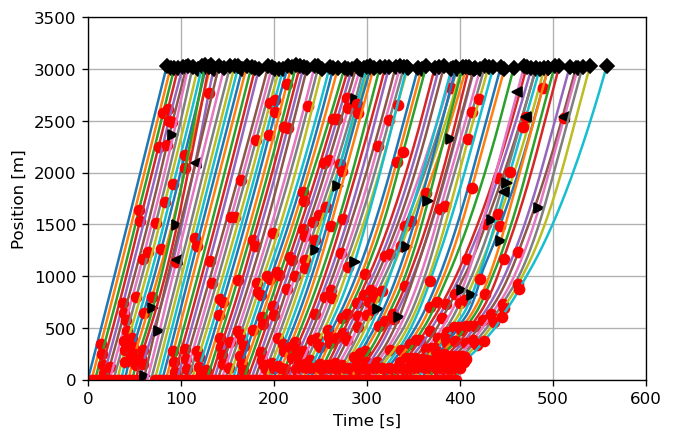

In [453]:
rec.plot('t', 'x',xmin=0, xmax=600, ymin=0, ymax=3500)

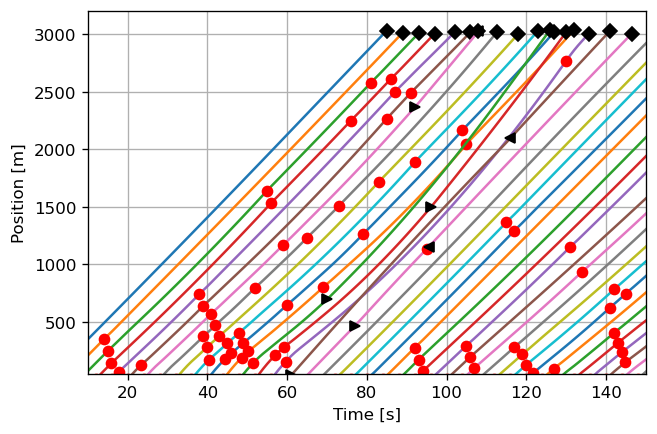

In [456]:
rec.plot('t', 'x', xmin=10, xmax=150, ymin=50, ymax=3200)

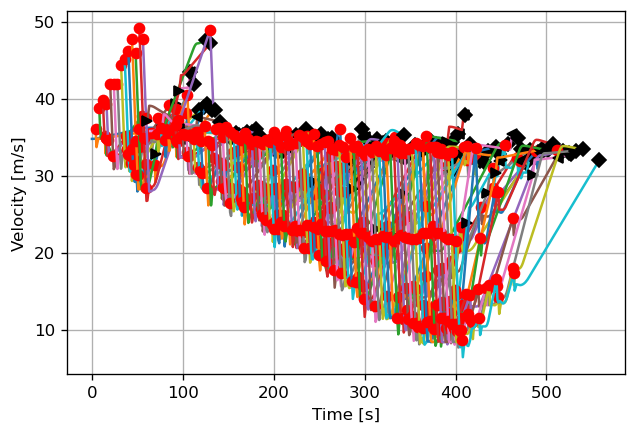

In [457]:
rec.plot('t', 'v')

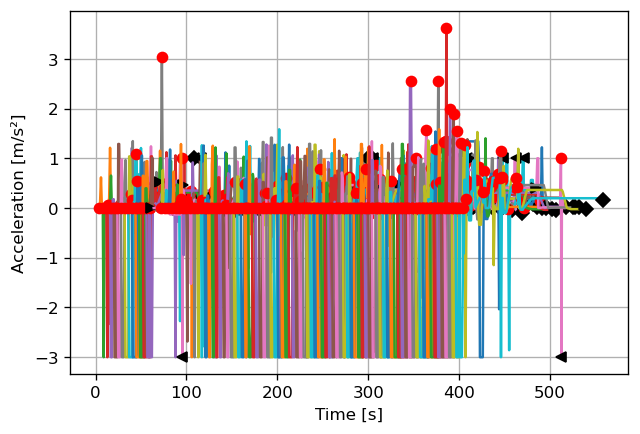

In [458]:
rec.plot('t', 'a')

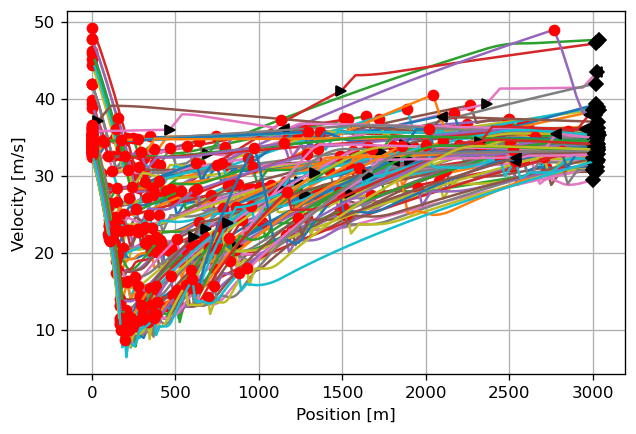

In [459]:
rec.plot('x', 'v')

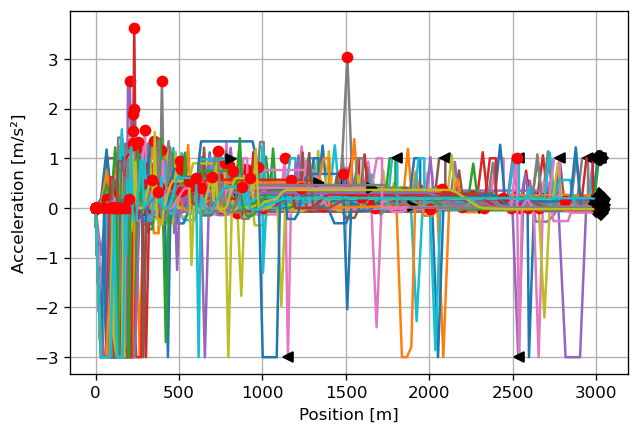

In [460]:
rec.plot('x', 'a')